## Import Libraries

In [5]:
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

## Load Data

In [6]:
csv = 'clean_tweet.csv'
my_df = pd.read_csv(csv,index_col=0)
my_df.head()

,text,target
0,awww that bummer you shoulda got david carr of...,0
1,is upset that he can not update his facebook b...,0
2,dived many times for the ball managed to save ...,0
3,my whole body feels itchy and like its on fire,0
4,no it not behaving at all mad why am here beca...,0


In [7]:
my_df.dropna(inplace=True)
my_df.reset_index(drop=True,inplace=True)
my_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596041 entries, 0 to 1596040
Data columns (total 2 columns):
text      1596041 non-null object
target    1596041 non-null int64
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


### Defining Input and Output for the Model

In [8]:
x = my_df.text
y = my_df.target

### Train Test Split with 80% - 20%

In [21]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from time import time
SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [49]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time, sentiment_fit

In [47]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cvec = CountVectorizer()
lr = LogisticRegression()
n_features = np.arange(10000,100001,10000)

def nfeature_accuracy_checker(vectorizer=cvec, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=lr):
    result = []
    print (classifier)
    print ("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Validation result for {} features".format(n))
        nfeature_accuracy,tt_time,_ = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,nfeature_accuracy,tt_time))
    return result

### TFIDF Vectorizer

TF-IDF is another way to convert textual data to a numeric form and is short for Term Frequency-Inverse Document Frequency. The vector value it yields is the product of these two terms; TF and IDF.

Let's first look at Term Frequency. We have already looked at term frequency above with count vectorizer, but this time, we need one more step to calculate the relative frequency. Let's say we have two documents in total as below.

1. I love dogs
2. I hate dogs and knitting

Relative term frequency is calculated for each term within each document as below.

$${TF(t,d)} = \frac {number\ of\ times\ term(t)\ appears\ in\ document(d)}{total\ number\ of\ terms\ in\ document(d)}$$

For example, if we calculate relative term frequency for 'I' in both document 1 and document 2, it will be as below.

$${TF('I',d1)} = \frac {1}{3} \approx {0.33}$$

$${TF('I',d2)} = \frac {1}{5} = {0.2}$$

Next, we need to get Inverse Document Frequency, which measures how important a word is to differentiate each document by following the calculation as below.

$${IDF(t,D)} = \log \Big(\frac {total\ number\ of\ documents(D)}{number\ of\ documents\ with\ the\ term(t)\ in\ it}\Big)$$

If we calculate inverse document frequency for 'I',

$${IDF('I',D)} = \log \Big(\frac {2}{2}\Big) = {0}$$

Once we have the values for TF and IDF, now we can calculate TFIDF as below.

$${TFIDF(t,d,D)} = {TF(t,d)}\cdot{IDF(t,D)}$$

Following the case of our example, TFIDF for term 'I' in both documents will be as below.

$${TFIDF('I',d1,D)} = {TF('I',d1)}\cdot{IDF('I',D)} = {0.33}\times{0} = {0}$$

$${TFIDF('I',d2,D)} = {TF('I',d2)}\cdot{IDF('I',D)} = {0.2}\times{0} = {0}$$

As you can see, the term 'I' appeared equally in both documents, and the TFIDF score is 0, which means the term is not really informative in differentiating documents. The rest is same as count vectorizer, TFIDF vectorizer will calculate these scores for terms in documents, and convert textual data into a numeric form.

#### How does Uni-Gram, Bi-Gram, Tri-Gram tokens work as the vocabulory of the dataset?

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer
tvec = TfidfVectorizer()
ttvec = TfidfVectorizer(ngram_range=(1,3))
ttvec.fit(["an apple a day keeps the doctor away"])
print(ttvec.vocabulary_)

{'away': 6, 'day': 7, 'keeps': 12, 'the': 15, 'doctor': 10, 'the doctor': 16, 'apple day keeps': 5, 'an apple day': 2, 'apple day': 4, 'an': 0, 'keeps the doctor': 14, 'keeps the': 13, 'apple': 3, 'doctor away': 11, 'day keeps': 8, 'an apple': 1, 'day keeps the': 9, 'the doctor away': 17}


## Evaluting what Feature Size (Vocabulory Size) and Token Method (Uni-Gram, Bi-Gram, Tri-Gram) works best on the dataset

In [24]:
%%time
print("RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_ugt = nfeature_accuracy_checker(vectorizer=tvec)

RESULT FOR UNIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 10000 features


E:\Workspace\IDE\winPython 3.5\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score: 79.74%
train and test time: 63.52s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 80.01%
train and test time: 60.16s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 80.12%
train and test time: 74.84s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 80.16%
train and test time: 77.53s
--------------------------------------------------------------------------------
Validation result for 50000 features
accuracy score: 80.21%
train and test time: 78.89s
--------------------------------------------------------------------------------
Validation result for 60000 features
accuracy score: 80.23%
train and test time: 79.08s
--------------------------------------------------------------------------------
Validation result for 7

In [40]:
%%time
print("RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_bgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 2))

RESULT FOR BIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 10000 features


E:\Workspace\IDE\winPython 3.5\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score: 80.70%
train and test time: 117.25s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 81.56%
train and test time: 124.81s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 81.95%
train and test time: 125.44s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 82.23%
train and test time: 137.23s
--------------------------------------------------------------------------------
Validation result for 50000 features
accuracy score: 82.31%
train and test time: 142.70s
--------------------------------------------------------------------------------
Validation result for 60000 features
accuracy score: 82.27%
train and test time: 146.80s
--------------------------------------------------------------------------------
Validation result

In [41]:
%%time
print("RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tvec,ngram_range=(1, 3))

RESULT FOR TRIGRAM WITH STOP WORDS (Tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


Validation result for 10000 features


E:\Workspace\IDE\winPython 3.5\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score: 80.72%
train and test time: 227.31s
--------------------------------------------------------------------------------
Validation result for 20000 features
accuracy score: 81.55%
train and test time: 235.33s
--------------------------------------------------------------------------------
Validation result for 30000 features
accuracy score: 81.96%
train and test time: 242.87s
--------------------------------------------------------------------------------
Validation result for 40000 features
accuracy score: 82.26%
train and test time: 244.02s
--------------------------------------------------------------------------------
Validation result for 50000 features
accuracy score: 82.34%
train and test time: 234.88s
--------------------------------------------------------------------------------
Validation result for 60000 features
accuracy score: 82.43%
train and test time: 235.25s
--------------------------------------------------------------------------------
Validation result

It seems like TFIDF vectorizer is yielding better results when fed to logistic regression. Let's plot the results from  together with TFIDF vectorizer.

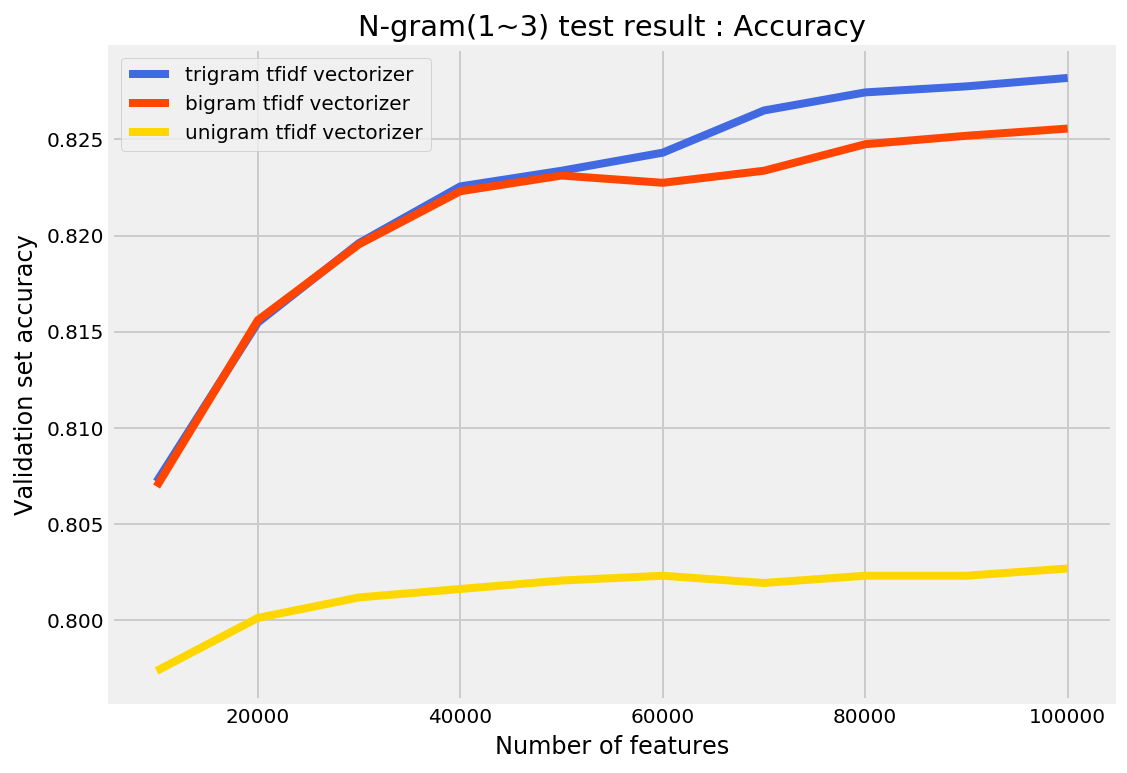

In [43]:
nfeatures_plot_tgt = pd.DataFrame(feature_result_tgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_bgt = pd.DataFrame(feature_result_bgt,columns=['nfeatures','validation_accuracy','train_test_time'])
nfeatures_plot_ugt = pd.DataFrame(feature_result_ugt,columns=['nfeatures','validation_accuracy','train_test_time'])

plt.figure(figsize=(8,6))
plt.plot(nfeatures_plot_tgt.nfeatures, nfeatures_plot_tgt.validation_accuracy,label='trigram tfidf vectorizer',color='royalblue')
plt.plot(nfeatures_plot_bgt.nfeatures, nfeatures_plot_bgt.validation_accuracy,label='bigram tfidf vectorizer',color='orangered')
plt.plot(nfeatures_plot_ugt.nfeatures, nfeatures_plot_ugt.validation_accuracy, label='unigram tfidf vectorizer',color='gold')
plt.title("N-gram(1~3) test result : Accuracy")
plt.xlabel("Number of features")
plt.ylabel("Validation set accuracy")
plt.legend()

From above chart, we can see including bigram and trigram boost the model performance both in count vectorizer and TFIDF vectorizer. And for every case of unigram to trigram, TFIDF yields better results than count vectorizer.

## Model Training

In [59]:
names = ["Logistic Regression"]
classifiers = [
    LogisticRegression()
    ]
zipped_clf = zip(names,classifiers)

In [60]:
tvec = TfidfVectorizer()
def classifier_comparator(vectorizer=tvec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    model= None
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', c)
        ])
        print("Validation result for {}".format(n))
        print(c)
        clf_accuracy,tt_time, model = accuracy_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_accuracy,tt_time))
    return result, model

In [61]:
%%time
trigram_result, model = classifier_comparator(n_features=100000,ngram_range=(1,3))

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


E:\Workspace\IDE\winPython 3.5\WinPython-64bit-3.5.3.1Qt5\python-3.5.3.amd64\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy score: 82.82%
train and test time: 233.42s
--------------------------------------------------------------------------------
Wall time: 3min 53s


In [62]:
print(trigram_result)

[('Logistic Regression', 0.8281954887218045, 233.4237082004547)]


### Testing Training Model on some other tweets for Sanity Testing

In [83]:
sentences = ["The weather is not very well today. i wish it was raining",
             "a real bad example of customer engagement",
             "glad to be part of the venture"]

predictions = []
predictions_conf = []

for s in sentences:
    predictions.append(model.predict(pd.Series(s)))
    predictions_conf.append(model.predict_proba(pd.Series(s)))

print(model.classes_)
#print(predictions, predictions_conf)
# print("%s %s %s %s")
i = 1
for p, pc in zip(predictions, predictions_conf):
    print("Tweet {} is classified as {} with confidence (0,1) {}".format(i, p, pc))
    i = i+1


[0 1]
Tweet 1 is classified as [0] with confidence (0,1) [[0.98841197 0.01158803]]
Tweet 2 is classified as [0] with confidence (0,1) [[0.57675026 0.42324974]]
Tweet 3 is classified as [1] with confidence (0,1) [[0.03883742 0.96116258]]
